<a href="https://colab.research.google.com/github/Ranjan4Kumar/Digit_Recognization_Using_TF/blob/main/Digit_Recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Libraries and Settings

In [2]:
from io import IncrementalNewlineDecoder
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf

In [3]:
# Setting up 
learning_rate = 1e-4

# set 20000 on local environment to get best accuracy

training_iteration = 2500
dropout = 0.5
batch_size = 50

# set to 0 to train on all available data
validation_size = 2000

# image number to output
image_to_display = 10

### Data preparation

To start, we read provided data. The train.csv file contains 42000 rows and 785 columns. Each row represents an image of a handwritten digit and a label with the value of this digit

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
data = pd.read_csv('/content/drive/MyDrive/DS/TensorFlow Deep NN/train 2.csv')
print('data({0[0]},{0[1]})'.format(data.shape))
data.head()

data(42000,785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


############### Every image is streched array of pixel values.

In [6]:
images = data.iloc[:,1:].values
images = images.astype(float)

# convert from [0:255] => [0.0:1.0]

images = np.multiply(images , 1.0 / 255.0)

print('image({0[0]},{0[1]})'.format(images.shape))

image(42000,784)


In [7]:
image_size = images.shape[1]
print('image_size => {0}'.format(image_size))

# in this class all images are squared

image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)

print('image_width => {0}\nimage_height => {1}'.format(image_width,image_height))

print('If image size would be 784 than the image height and width will be equally divided=> 28*28')

image_size => 784
image_width => 28
image_height => 28
If image size would be 784 than the image height and width will be equally divided=> 28*28


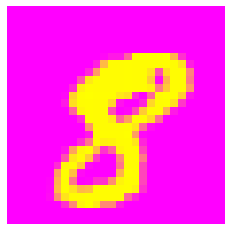

In [8]:
# display image
def display(img):

  #(784) = > (28,28)

  one_image = img.reshape(image_width , image_height)
  plt.axis('off')
  plt.imshow(one_image , cmap = cm.spring) 

  # cmap-> color map ,  cm.binary, cm.gist_gray ,cm.gist_yarg, cm.gray, cm.bone , cm.pink , cm.summer , cm.autumn , cm.winter , cm.cool , cm.Wistia , cm.hot , cm.afmhot , cm.gist_heat, cm.copper


# output image
display(images[image_to_display])

##### Corresponding labels are numbers between 0 and 9, describing which digit a given image is of.

In [9]:
labels_flat = data.iloc[: , 0].values.ravel()
#The numpy.ravel() functions returns contiguous flattened array(1D array with all the input-array elements and with the same type as it). A copy is made only if needed. 
"""
The contiguous flattened array is a two-dimensional and multi-dimensional array that is stored as a one-dimensional array. We will be using the ravel() method to perform this task. 
Syntax : numpy.ravel(array, order = 'C') Parameter
"""
print('labels_flat({0})'.format(len(labels_flat)))

print('labels_flat[{0}] => {1}'.format(image_to_display, labels_flat[image_to_display]))

labels_flat(42000)
labels_flat[10] => 8


In [10]:
labels_count = np.unique(labels_flat).shape[0]
print('labels_count => {0}'.format(labels_count))

labels_count => 10


#### For most of the classification problems "one-hot vectors are used. A one-hot vector is a vector that contains a single element equal to 1 and the rest of the element equal to 0. In this case, the nth digit is represented as a zero vector with 1 in the nth position.

In [11]:
# Convert the class labels from scaler to one-hot vectors
# 0=> [1 0 0 0 0 0 0 0 0 0 ]
# 1=> [0 1 0 0 0 0 0 0 0 0 ]
# ......
# 9=> [0 0 0 0 0 0 0 0 0 1 ]

def dense_to_one_hot(labels_dense,num_classes):
  num_labels = labels_dense.shape[0]
  index_offset = np.arange(num_labels)*num_classes
  labels_one_hot = np.zeros((num_labels,num_classes))
  labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
  return labels_one_hot 

labels = dense_to_one_hot(labels_flat , labels_count)
labels = labels.astype(np.uint8)

print('labels{0[0]},{0[1]}'.format(labels.shape))
print('labels[{0}] => {1}'.format(image_to_display, labels[image_to_display]))

labels42000,10
labels[10] => [0 0 0 0 0 0 0 0 1 0]


#### Lastly we set aside data for validation. It's essential in machine learning to have a separate dataset which doesn't take part in the training and is used to make sure that what we've learned can actually be generalised.

In [12]:
# split data into training & validation

validation_images = images[: validation_size]
validation_lables = labels[: validation_size]


train_images = images[validation_size :]
train_labels = labels[validation_size :]

print('train_images({0[0]}) , {0[1]}'.format(train_images.shape))
print('validation_images({0[0]},{0[1]}'.format(validation_images.shape))

train_images(40000) , 784
validation_images(2000,784


#### Data is ready. The neural network structure is next


## TensorFlow graph

TensorFlow does its heavy lifting outside Python. Therefore, instead of running every single operation independently, TensorFlow allows user to build a whole graph of interacting operations and then runs the workflow in a seperate process at once.


## Helper functions

For this NN model, a lot of wights and bisases are created. Generally, weights should be intialised with a small amount of noise for symmetry breaking, and to prevent 0 gradients.

Since we are using ReLU neurons(ones that contians rectifier function f(x) = max(0,x), it is also good practice to intialise them with slightly positive initial bias to avoid "dead neurones".

In [13]:
# Wight initialization

def weight_vairable(shape):
  initial = tf.random.truncated_normal(shape , stddev = 0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1 , shape=shape)
  return tf.Variable(initial)

##### For this problem we use '0' padded "convolution" so that the output is the same size as the input. Stride/step in this case is equal to 1.


##### In general, convolution layer is used to get the feature of the data. In the case of digit recognition-a shape of each digit. It uses learnable kernels/filters each of which corresponds to one particular shape pattern. The number of the filter can differ for other.

In [14]:
# Convolution

def conv2d(x, W):
  return tf.nn.conv2d(x ,W ,strides=[1,1,1,1] , padding = 'SAME')

##### pooling is plain max pooling over 2X2 blocks

Pooling is used for downsampling of the data. 2X2 max-pooling splits the image into square 2-pixel blocks and only keeps maximum value for each of those blocks

In [15]:
# pooling
#[[0,3],
# [4,2]] =>4

# [[ 0 , 1],
# [1 , 1]] => 1

def max_pool_2X2(x):
  return tf.nn.max_pool(x , ksize=[1,2,2,1], strides = [1,2,2,1] , padding = 'SAME')

We'll get back to convolutions and pooling in more detail below.

The good thing about neural networks that any NN can be used as a layer in a large multilayer NN meaning that output of one can be used as input for another. This sequential approach can create very sophisticated NN with multiple layers. They are also called Deep Neural Networks.


In this case, we use two convolution layer with pooling in between them , then denesly connected layer followed by dropout and lastly readout layer.

In [16]:
# input & output of NN
#images
import tensorflow.compat.v1 as tf_1

tf_1.disable_v2_behavior()
x = tf_1.placeholder(shape=[None, image_size], dtype=tf.float32)
y_ = tf_1.placeholder(shape = [None , labels_count], dtype=tf.float32)
#x = tf.placeholder('float' , shape = [None , image_size])

# labels

#y_ = tf.placeholder('float' , shape =[None , labels_count])

Instructions for updating:
non-resource variables are not supported in the long term


The First layer is a convolution, followed by max pooling. The convolution computes 32 features for each 5X5 patch. Its weight tensor has a shape[5,5,1,32]. The first two dimensions are the patch size, the next is the number of input channels(1 means that image are grayscale), and the final dimension-to the number of colour channels.

After the convolution, pooling reduces the size of the output from 28X28 to 14X14

In [17]:
W_conv1 = weight_vairable([5,5,1,32])
b_conv1 = bias_variable([32])

# (40000,784) => (40000,28,28,1)

image = tf.reshape(x, [-1, image_width, image_height, 1])
# print (image.get_shap()) # => (40000,28,28,1)

h_conv1= tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
# print(h_conv1.get_shape()) => (40000,28,28,1)
h_pool1 = max_pool_2X2(h_conv1)
# print(h_pool1.get_shape()) =>(40000,14,14,32)
#prepare for visualization
# display 32 feature in 4 by 8 grid

layer1 = tf.reshape(h_conv1, (-1, image_height, image_width, 4, 8))

# reorder so the channels are in the 1st dimenssion, x and y follow

layer1 = tf.transpose(layer1 , (0,3,1,4,2))
layer1 = tf.reshape(layer1, (-1, image_height*4 , image_width*8))


The second layer has 64 features for each 5X5 patch. Its weight tensor has a shape of [5,5,32,64]. The first two dimenssion are the patch size, the next is the number of input channels(32 channels corresponds to 32 features that we got from previous convolutional layer), and the last is the number of output channels. There is also a bias vector with a component for each output channel.


beacuse the image is down-sampled by pooling 14X14 size second convolutional layer picks up more general characteristics of the images. Filters cover more spaces of the picture. Therefore, it is adjusted for more generic features while the 1st layer finds smaller details.

In [18]:
W_conv2 = weight_vairable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
#print (h_conv2.get_shape()) # => (40000, 14,14, 64)
h_pool2 = max_pool_2X2(h_conv2)
#print (h_pool2.get_shape()) # => (40000, 7, 7, 64)

# Prepare for visualization
# display 64 fetures in 4 by 16 grid
layer2 = tf.reshape(h_conv2, (-1, 14, 14, 4 ,16))  

# reorder so the channels are in the first dimension, x and y follow.
layer2 = tf.transpose(layer2, (0, 3, 1, 4,2))

layer2 = tf.reshape(layer2, (-1, 14*4, 14*16)) 

Now that the image size is reduced to 7X7, we add a fully-connetced layer with 1024 neurons to allow processing on the entire image(each of the neurons of the fully connected layer is connected to all the activations/output of the previous layer)

In [19]:
# densely connected layer
W_fc1 = weight_vairable([7*7*64, 1024])
b_fc1 = bias_variable([1024])

#(40000, 7 ,7, 64) => (40000,3136)

h_pool2_flat = tf.reshape(h_pool2 , [-1,7*7*64])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat ,W_fc1) + b_fc1)

#print (h_fc1.get_shape()) # => (40000,1024)

To prevent overfitting, we apply "Dropout" before the readout layer.

Dropout removes some nodes from the network at each training stage.  Each of the nodes is eigther kept in the network with probability keep_prob of dropped with probability 1-keep_prob. After the training stage is over the nodes are returned to the NN with their original weights

In [20]:
# dropout

keep_prob = tf_1.placeholder(dtype = tf.float32)

h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

"""
Finally, we add a softmax layer, the same one if we use just a simple softmax regression

"""

'\nFinally, we add a softmax layer, the same one if we use just a simple softmax regression\n\n'

In [21]:
# readout layer for deep net

W_fc2 = weight_vairable([1024, labels_count])
b_fc2 = bias_variable([labels_count])

y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

#print (y.get_shape()) # => (40000, 10)

To Evaluate network performance we use cross-entropy and to minimise it ADAM Optimiser is used.


ADAM optimiser is a gradient based optimization algorithm, based on adaptive estimate, it's more sophisticated then steepest gradient descent and is well suited for problems with large data or many parameters.

In [32]:
# Cost- functions or Loss functions
import math
cross_entropy = -tf.reduce_sum(y_*tf.math.log(y))

# optimization function

train_step = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(cross_entropy)


# Evaluation
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

TO predict values from test data, highest probability is picked from "one-hot vector" indicating that chances of an image being one of the digits are highest.



### Prediction function



In [34]:
# [0.1, 0.9, 0.2, 0.1, 0.3, 0.5, 0.1, 0.2, 0.3]=> 1

predict = tf.argmax(y,1)
predict

<tf.Tensor 'ArgMax_5:0' shape=(?,) dtype=int64>

Finally neural nerwork structure is defined and TensorFlow graph is ready for training



### Train , Validate and Predict

##### Helper function

Ideally, we should use all data for every step of the training, but that's exxpensive. So, instead, we use small "batches" of random data.


##### This method is called "Stochastic training". It is cheaper, faster and gives ,much of the same result.

In [48]:
epochs_completed = 0
index_in_epoch = 0
num_examples = train_images.shape[0]

# serve data by batches

def next_batch(batch_size):
  global train_images
  global train_labels
  global index_in_epoch
  global epochs_completed

  start = index_in_epoch
  index_in_epoch += batch_size

  # when all training data have been already used, it is reorder randomly


  if index_in_epoch > num_examples:

    # finished epoch

    epochs_completed += 1

    # shuffle the data
    perm = np.arange(num_examples)
    np.random.shuffle(perm)
    train_images = train_images[perm]
    train_labels = train_labels[perm]

    # start next epoch

    start = 0
    index_in_epoch = batch_size
    assert batch_size <= num_examples
  end  = index_in_epoch

  return train_images[start:end], train_labels[start:end]

In [49]:
'''
Now when all operations for every varaible are defined in TensorFlow graph all computation will be performed outside Python environment.

'''

init = tf.compat.v1.global_variables_initializer()
sess = tf.compat.v1.InteractiveSession()

sess.run(init)

Each step of the loop, we get a "batch" of data points from the training set and feed it to the graph to replace the placeholder. In this case, it's x,y and dropout.


Also, once in a while, we check training accuracy on an upcomming "batch"

On the local environment, we recommend saving training progress, so it can be recovered for further training, debuggig or evaluation.

In [50]:
# visulisation variables

train_accuracies = []
validation_accuracies = []
x_range = []

display_step = 1
for i in range(training_iteration):

    #get new batch
    batch_xs, batch_ys = next_batch(batch_size)        

    # check progress on every 1st,2nd,...,10th,20th,...,100th... step
    if i%display_step == 0 or (i+1) == training_iteration:
        
        train_accuracy = accuracy.eval(feed_dict={x:batch_xs, 
                                                  y_: batch_ys, 
                                                  keep_prob: 1.0})       
        if(validation_size):
            validation_accuracy = accuracy.eval(feed_dict={ x: validation_images[0:batch_size], 
                                                            y_: validation_lables[0:batch_size], 
                                                            keep_prob: 1.0})                                  
            print('training_accuracy / validation_accuracy => %.2f / %.2f for step %d'%(train_accuracy, validation_accuracy, i))
            
            validation_accuracies.append(validation_accuracy)
            
        else:
             print('training_accuracy => %.4f for step %d'%(train_accuracy, i))
        train_accuracies.append(train_accuracy)
        x_range.append(i)
        
        # increase display_step
        if i%(display_step*10) == 0 and i:
            display_step *= 10
    # train on batch
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: dropout})

training_accuracy / validation_accuracy => 0.14 / 0.10 for step 0
training_accuracy / validation_accuracy => 0.12 / 0.10 for step 1
training_accuracy / validation_accuracy => 0.18 / 0.10 for step 2
training_accuracy / validation_accuracy => 0.06 / 0.10 for step 3
training_accuracy / validation_accuracy => 0.06 / 0.10 for step 4
training_accuracy / validation_accuracy => 0.10 / 0.10 for step 5
training_accuracy / validation_accuracy => 0.06 / 0.10 for step 6
training_accuracy / validation_accuracy => 0.14 / 0.10 for step 7
training_accuracy / validation_accuracy => 0.10 / 0.10 for step 8
training_accuracy / validation_accuracy => 0.10 / 0.10 for step 9
training_accuracy / validation_accuracy => 0.16 / 0.10 for step 10
training_accuracy / validation_accuracy => 0.10 / 0.10 for step 20
training_accuracy / validation_accuracy => 0.04 / 0.10 for step 30
training_accuracy / validation_accuracy => 0.14 / 0.10 for step 40
training_accuracy / validation_accuracy => 0.10 / 0.10 for step 50
train

validation_accuracy => 0.0980


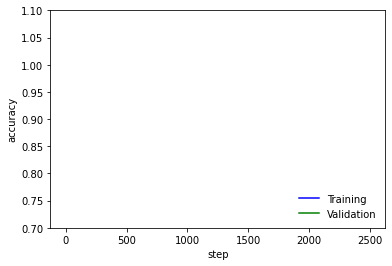

In [52]:
# check final accuracy on validation set  
if(validation_size):
    validation_accuracy = accuracy.eval(feed_dict={x: validation_images, 
                                                   y_: validation_lables, 
                                                   keep_prob: 1.0})
    print('validation_accuracy => %.4f'%validation_accuracy)
    plt.plot(x_range, train_accuracies,'-b', label='Training')
    plt.plot(x_range, validation_accuracies,'-g', label='Validation')
    plt.legend(loc='lower right', frameon=False)
    plt.ylim(ymax = 1.1, ymin = 0.7)
    plt.ylabel('accuracy')
    plt.xlabel('step')
    plt.show()

<ipython-input-53-931264457e1d>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_images = test_images.astype(np.float)


test_images(28000,784)
predicted_lables(28000)
predicted_lables[10] => 0.0


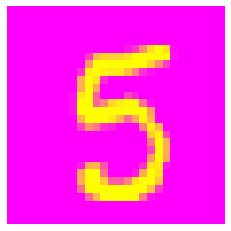

In [53]:
# read test data from CSV file 
test_images = pd.read_csv('/content/drive/MyDrive/DS/TensorFlow Deep NN/test.csv').values
test_images = test_images.astype(np.float)

# convert from [0:255] => [0.0:1.0]
test_images = np.multiply(test_images, 1.0 / 255.0)

print('test_images({0[0]},{0[1]})'.format(test_images.shape))


# predict test set
#predicted_lables = predict.eval(feed_dict={x: test_images, keep_prob: 1.0})

# using batches is more resource efficient
predicted_lables = np.zeros(test_images.shape[0])
for i in range(0,test_images.shape[0]//batch_size):
    predicted_lables[i*batch_size : (i+1)*batch_size] = predict.eval(feed_dict={x: test_images[i*batch_size : (i+1)*batch_size], 
                                                                                keep_prob: 1.0})


print('predicted_lables({0})'.format(len(predicted_lables)))

# output test image and prediction
display(test_images[image_to_display])
print ('predicted_lables[{0}] => {1}'.format(image_to_display,predicted_lables[image_to_display]))

# save results
np.savetxt('submission_softmax.csv', 
           np.c_[range(1,len(test_images)+1),predicted_lables], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')

#### Appendix
As it was mentioned before, it is good to output some variables for a better understanding of the process.

Here we pull an output of the first convolution layer from TensorFlow graph. 32 features are transformed into an image grid, and it's quite interesting to see how filters picked by NN outline characteristics of different digits.

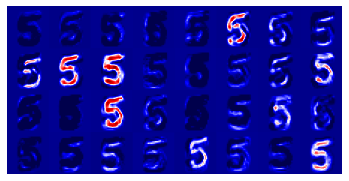

In [54]:
layer1_grid = layer1.eval(feed_dict={x: test_images[image_to_display:image_to_display+1], keep_prob: 1.0})
plt.axis('off')
plt.imshow(layer1_grid[0], cmap=cm.seismic )